# Task 2.1

“Given a video of the modal mask of an object, predict the amodal mask of the same object”

Inputs:
- RGB Frames - N 3-channel images (N, 3, 256, 256)
- N Modal Masks of Object i - N Binary (1-channel) images (N, 1, 256, 256)

Outputs:
- N Amodal Masks of Object i - N Binary (1-channel) images (1, 256, 256)

In [2]:
# PyTorch, Torchvision
import torch
from torch import nn
from torchvision.transforms import ToPILImage, ToTensor
from torchvision.utils import make_grid
from torchvision.io import write_video

# Common
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import json
from IPython.display import Video

# Utils from Torchvision
tensor_to_image = ToPILImage()
image_to_tensor = ToTensor()

In [3]:
torch.cuda.is_available()

True

In [3]:
!nvidia-smi

Tue Jul 15 15:42:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla M60                      On  |   00000000:04:00.0 Off |                    0 |
| N/A   22C    P8             15W /  150W |       3MiB /   7680MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Model

In [4]:

def calculate_metrics(amodal_mask_preds, 
                      amodal_mask_labels, 
                      amodal_content_preds,
                      amodal_content_labels):
    """
    Here, you can calculate non-loss metrics like mIOU, accuracy, J&F scores.

    And non-loss image generation metrics between the predicted and ground-truth amodal content
    Such as Inception Score, Frechet Inception Distance, Learned Perceptual Patch Similarity (LPIPS),
    Structure Similarity Index Metric (SSIM), Peak Signal-Noise Ratio (PSNR)

    These should all have easy-to-use implementations in libraries such as TorchMetrics.
    """
    return None


#### Class - Unet_Image

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class conv2d_inplace_spatial(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, pooling_function, activation = nn.GELU()):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            activation,
            pooling_function,
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Upscale(nn.Module):
    def __init__(self, scale_factor=(2, 2), mode='bilinear', align_corners=False):
        super(Upscale, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.align_corners = align_corners

    def forward(self, x):
        return F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode, align_corners=self.align_corners)

class Unet_Image(nn.Module):
    def __init__(self, in_channels = 4, mask_content_preds = False):
        super().__init__()
        # downsampling
        # MaxPooling - keep max value over a 2x2 sliding window
        self.mpool_2 = nn.MaxPool2d((2, 2))
        
        # down path - encoding - increase dimensions
        self.down1 = conv2d_inplace_spatial(in_channels, 32, self.mpool_2) # 32 x 32
        self.down2 = conv2d_inplace_spatial(32, 64, self.mpool_2) # 64 x64 
        self.down3 = conv2d_inplace_spatial(64, 128, self.mpool_2) # 128 x128
        self.down4 = conv2d_inplace_spatial(128, 256, self.mpool_2) # outputs 256 x256
        
        # upsample by factor of 2, in both dimensions
        self.upscale_2 = Upscale(scale_factor=(2, 2), mode='bilinear', align_corners=False)
        
        # up path - decoder
        # slowly reduce dimensions
        self.up1 = conv2d_inplace_spatial(256, 128, self.upscale_2)
        self.up2 = conv2d_inplace_spatial(256, 64, self.upscale_2)
        self.up3 = conv2d_inplace_spatial(128, 32, self.upscale_2)
        
        # no activation
        self.up4_amodal_mask = conv2d_inplace_spatial(64, 1, self.upscale_2, activation = nn.Identity())
        self.up4_amodal_content = conv2d_inplace_spatial(64, 3, self.upscale_2, activation = nn.Identity())

        # Optional arguments
        self.mask_content_preds = mask_content_preds # Should we mask the amodal content prediction by the amodal mask prediction?

        # Optimization
        self.mse_loss = nn.L1Loss()
        self.bce_loss = nn.BCEWithLogitsLoss()


        # Self-attention feature enrichment
        #max_seq = 16*16*6
        #token_dim = 256
        #self.pos_enc = nn.Parameter(torch.zeros((max_seq, 1, token_dim))) # seq b dim
        #encoder_layer = nn.TransformerEncoderLayer(d_model=token_dim, nhead=8)
        #self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)
    
    # Packages the encoder path (downpath)
    def encode(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        
        # Returns the four
        # [torch.Size([6, 32, 4, 128, 128]), torch.Size([6, 64, 2, 64, 64]), torch.Size([6, 128, 1, 32, 32]), torch.Size([6, 256, 1, 16, 16])]
        return x1, x2, x3, x4
    
    # packages the decode path (up-path)
    def decode(self, h1, h2, h3, h4):
        h4 = self.up1(h4) # 6, 256, 1, 16, 16 -> 6, 128, 1, 32, 32 (double spatial, then conv-in-place channels to half)
        h34 = torch.cat((h3, h4), dim = 1) # (6, 2*128, 1, 32, 32)

        h34 = self.up2(h34) # 6, 256, 1, 32, 32 -> 6, 128, 2, 64, 64
        h234 = torch.cat((h2, h34), dim = 1)

        h234 = self.up3(h234)
        h1234 = torch.cat((h1, h234), dim = 1)
        
        logits_amodal_mask = self.up4_amodal_mask(h1234)
        logits_amodal_content = self.up4_amodal_content(h1234)
        return logits_amodal_mask, logits_amodal_content
    
    # Encode - decode together
    # Runs through the whole model
    def encode_decode(self, x):
        """
        input image tensor: (bs, c, h, w) - batch size, channels, height, width
        """
        b, c, h, w = x.shape

        # Multiscale features x1, x2, x3, x4
        x1, x2, x3, x4 = self.encode(x)

        # You could add code here for example more layers that modify the latent x4? Be creative :)

        # Decode using enriched features
        logits_amodal_mask, logits_amodal_content = self.decode(x1, x2, x3, x4)

        return logits_amodal_mask, logits_amodal_content
        
    def forward(self, batch):
        # This takes in a batch
        # RGB image batch of shape (bs, c, n_frames, h, w)
        # modal_mask (binary, c=1) batch of shape (bs, c, n_frames, h, w)
        # concat rgb and modal masks as input to model
        model_input = torch.cat((batch['frames'], batch['modal_masks']), dim = 1)

        # Remove time dimension from a few things (add it back in later when you make your video model!)
        model_input = model_input.squeeze(2) # remove time dimension (you will probably want it later!)
        # This is what we use for loss calculations
        # These both have range 0 to 1 - same to logits
        amodal_mask_labels = batch['amodal_masks'].float().squeeze(2)
        amodal_content_labels = batch['amodal_content'].float().squeeze(2)

        # Model input
        #print('model input:', model_input.shape)
        
        logits_amodal_mask, logits_amodal_content = self.encode_decode(model_input)

        # Should we mask the amodal content prediction by the predicted amodal mask?
        if self.mask_content_preds:
            # Element-wise masking by self-predictions:
            logits_amodal_content = logits_amodal_mask.sigmoid().round() * logits_amodal_content

        # print('0000 Verify Shapes 0000')
        # print(logits_amodal_mask.shape)
        # print(logits_amodal_content.shape)
        # print(amodal_mask_labels.shape)
        # print(amodal_content_labels.shape)
        # Loss between predicted amodal masks/content and GT masks/content
        mask_loss, content_loss = self.loss_function(logits_amodal_mask, 
                                                        amodal_mask_labels,
                                                        logits_amodal_content, 
                                                        amodal_content_labels)
        
        loss = mask_loss + content_loss

        # Calculate metrics into a dictionary
        metrics = calculate_metrics(logits_amodal_mask, 
                                    amodal_mask_labels, 
                                    logits_amodal_content,
                                    amodal_content_labels)
        
        # Report the metrics we calculated in addition to our loss functions
        metrics = {
            'loss': loss.data.item(),
            'mask_loss': mask_loss.data.item(),
            'content_loss': content_loss.data.item(),
            'other_metrics_to_monitor': 0 # add more metrics here - just make sure they are a number
        }
        return loss, metrics
    def loss_function(self,
                    amodal_mask_preds,
                    amodal_mask_labels,
                    amodal_content_preds,
                    amodal_content_labels):
        # Compares raw logits for binary prediction - object vs no object
        mask_loss = self.bce_loss(amodal_mask_preds, amodal_mask_labels) # Binary Cross Entropy Loss
        # Pixel by pixel difference in the RGB
        content_loss = self.mse_loss(amodal_content_preds, amodal_content_labels) # L1 loss
        return mask_loss, content_loss

#### Example Usage

Test model usage

In [7]:
# Make a U-net which expects a batch of 4-channel images as input (batch_size, channels=4, height, width)
model = Unet_Image(4)

# Make a dummy tensor to test the model can successfully apply its layers and get an output
batch_size = 1
rand_input = torch.randn((batch_size, 4, 256, 256))

# Apply the model to the input - we use encode decode here rather than forward
# because we don't have the full batch yet - we will later
logits_amodal_mask, logits_amodal_content = model.encode_decode(rand_input)
print('Model output:', logits_amodal_mask.shape, logits_amodal_content.shape)
del logits_amodal_mask, logits_amodal_content
# For our use-case, we are predicting amodal masks and amodal content
# The amodal mask prediction should be (batch_size, 1, h, w) for a binary mask and the 
# Amodal content prediction should be  (batch_size, 3, h, w) for an rgb object prediction

Model output: torch.Size([1, 1, 256, 256]) torch.Size([1, 3, 256, 256])


## ConvLSTM + Unet

In [6]:
# from https://github.com/ndrplz/ConvLSTM_pytorch/blob/master/convlstm.py
# import torch.nn as nn
# import torch

# This processes one time step at a time
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        # 2d convolution
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


# Stacks multiple LSTM cells on top of each other
class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W (T=time)
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [9]:
class Unet_Image_ConvLSTM(Unet_Image):
    def __init__(self, in_channels=4, mask_content_preds=False):
        super().__init__(in_channels, mask_content_preds)
        # Inserting the convLSTM from above
        # One layer
        self.convlstm = ConvLSTM(
            input_dim=256,        # matches self.down4 out_channels
            hidden_dim=256,       # can be same as input_dim or different
            kernel_size=(3, 3),
            num_layers=1,
            batch_first=True,     # input should be (batch, time, channels, h, w)
            bias=True,
            return_all_layers=False
        )


    def encode_frames(self, x, n_frames):
        # Encode each frame
        # Remember time dimension is in the second 
        x1_seq, x2_seq, x3_seq, x4_seq = [], [], [], []
        for t in range(n_frames):
            # Here we pass all batches (dim=0), for this timestep (dim=1)
            x1, x2, x3, x4 = self.encode(x[:, t, :, :])  # Each: (bs, channels, h, w)
            x1_seq.append(x1)
            x2_seq.append(x2)
            x3_seq.append(x3)
            x4_seq.append(x4)
        # Stack along time dimension
        x1_seq = torch.stack(x1_seq, dim=1)  # (bs, n_frames, channels, h, w)
        x2_seq = torch.stack(x2_seq, dim=1)
        x3_seq = torch.stack(x3_seq, dim=1)
        x4_seq = torch.stack(x4_seq, dim=1)
        return x1_seq, x2_seq, x3_seq, x4_seq
    
    
    def decode_frames(self, x1_seq, x2_seq, x3_seq, convlstm_out, n_frames):
        logits_amodal_mask_seq = []
        logits_amodal_content_seq = []

        # Time dimension is in dim = 1 (second dimension)
        for t in range(n_frames):
            h4 = convlstm_out[:, t]  # (bs, channels, h, w)
            # Use skip connections from the corresponding frame
            h1 = x1_seq[:, t]
            h2 = x2_seq[:, t]
            h3 = x3_seq[:, t]
            logits_mask, logits_content = self.decode(h1, h2, h3, h4)
            logits_amodal_mask_seq.append(logits_mask)
            logits_amodal_content_seq.append(logits_content)

        # Stack to get (bs, n_frames, ...)
        logits_amodal_mask_seq = torch.stack(logits_amodal_mask_seq, dim=1)
        logits_amodal_content_seq = torch.stack(logits_amodal_content_seq, dim=1)
        return logits_amodal_mask_seq, logits_amodal_content_seq
    
    def forward(self, batch):
        # This takes in a batch
        # RGB image batch of shape (bs, c, n_frames, h, w)
        # modal_mask (binary, c=1) batch of shape (bs, c, n_frames, h, w)
        # concat rgb and modal masks as input to model

        # frames: (bs, c, n_frames, h, w)
        # modal_masks: (bs, 1, n_frames, h, w)
        frames = batch['modal_rgb']         # (bs, c, n_frames, h, w)
        modal_masks = batch['modal_masks']  # (bs, 1, n_frames, h, w)
        # mask the frames - this is masked modal RGB
        frames = modal_masks * frames 
        # bs, c, n, h, w = frames.shape
        

        # # Concatenate along channel dim: (bs, c+1, n_frames, h, w)
        # model_input = torch.cat((frames, modal_masks), dim=1)

        # This time we don't squeeze the time dimension out
        # Prep for loss
        # This is what we use for loss calculations
        # Remember these are bs, c, n, h, w!
        # These both have range 0 to 1 - same to logits
        amodal_mask_labels = batch['amodal_masks'].float()
        amodal_content_labels = batch['amodal_content'].float()

        # Implementation here
        # # Concatenate along channel dim: (bs, c+1, n_frames, h, w)
        # model_input = torch.cat((frames, modal_masks), dim=1)
        x = torch.cat([frames, modal_masks], dim=1)  # (bs, 4, n_frames, h, w)
        bs, c, n_frames, h, w = x.shape
        # Unet_Image encode expects  (bs, 4, n_frames, h, w)
        # Permutation takes (bs, c, n_frames, h, w) --> (bs, n_frames, c, h, w)
        x = x.permute(0, 2, 1, 3, 4)  # (bs, n_frames, c, h, w) --> LSTM expects this

        # Encode frames
        x1_seq, x2_seq, x3_seq, x4_seq = self.encode_frames(x, n_frames)

        # Pass bottleneck (x4_seq) through ConvLSTM
        # Last layer should match dims from encode: torch.Size([6, 256, 1, 16, 16])]
        # ConvLSTM expects B, T, C, H, W
        convlstm_out_list, _ = self.convlstm(x4_seq)  # List of outputs for each layer
        # Returns layer_output_list, last_state_list
        # We only care about the layer output list
        convlstm_out = convlstm_out_list[0]           # (bs, n_frames, channels, h, w)

        # Decoding frames
        # Pass in the sequences of frames and the output of the LSTM
        # Will use the last frame for decoding
        logits_amodal_mask, logits_amodal_content = self.decode_frames(x1_seq, x2_seq, x3_seq, convlstm_out, n_frames)
        
        # Reshape logits - use permute
        # They come out as bs, n_frames, c, h, w
        # example:
        # torch.Size([8, 8, 3, 256, 256]) torch.Size([8, 8, 1, 256, 256])
        # Batch ground truth is: (bs, c, n_frames, h, w)
        # Example
        # torch.Size([8, 3, 8, 256, 256]) torch.Size([8, 1, 8, 256, 256])
        logits_amodal_mask = logits_amodal_mask.permute(0, 2, 1, 3, 4)
        logits_amodal_content = logits_amodal_content.permute(0, 2, 1, 3, 4)
        

        # Should we mask the amodal content prediction by the predicted amodal mask?
        if self.mask_content_preds:
            # Element-wise masking by self-predictions:
            logits_amodal_content = logits_amodal_mask.sigmoid().round() * logits_amodal_content

        # print('0000 Verify Shapes 0000')
        # print(logits_amodal_mask.shape)
        # print(logits_amodal_content.shape)
        # print(amodal_mask_labels.shape)
        # print(amodal_content_labels.shape)
        # Loss between predicted amodal masks/content and GT masks/content
        mask_loss, content_loss = self.loss_function(logits_amodal_mask, 
                                                        amodal_mask_labels,
                                                        logits_amodal_content, 
                                                        amodal_content_labels)
        
        loss = mask_loss + content_loss

        # Compute accuracy
        # If preds are probabilities/logits, binarize them:
        preds_mask = logits_amodal_mask.sigmoid().round() # make binary
        true_mask = amodal_mask_labels.round() # make these binary as well
        # Ensure labels are also float or int for comparison
        # Calculate number of correct pixels
        correct = (preds_mask == true_mask).float().sum()
        # Calculate total number of pixels (numel = number of total elements)
        total = torch.numel(preds_mask)
        # Accuracy
        accuracy = correct / total # this is a number 0 to 1

        # Calculate metrics into a dictionary
        metrics = calculate_metrics(logits_amodal_mask, 
                                    amodal_mask_labels, 
                                    logits_amodal_content,
                                    amodal_content_labels)
        
        # Report the metrics we calculated in addition to our loss functions
        metrics = {
            'loss': loss.data.item(),
            'mask_loss': mask_loss.data.item(),
            'content_loss': content_loss.data.item(),
            'accuracy': accuracy # add more metrics here - just make sure they are a number
        }
        return loss, metrics
    
    def loss_function(self,
                    amodal_mask_preds,
                    amodal_mask_labels,
                    amodal_content_preds,
                    amodal_content_labels):
        # Compares raw logits for binary prediction - object vs no object
        mask_loss = self.bce_loss(amodal_mask_preds, amodal_mask_labels) # Binary Cross Entropy Loss
        # Pixel by pixel difference in the RGB
        content_loss = self.mse_loss(amodal_content_preds, amodal_content_labels) # L1 loss
        return mask_loss, content_loss


NameError: name 'Unet_Image' is not defined

### Model dummy test

In [10]:
# Make a U-net which expects a batch of 4-channel images as input (batch_size, channels=4, height, width)
model = Unet_Image_ConvLSTM(in_channels=4, mask_content_preds=True)

# Make a dummy tensor to test the model can successfully apply its layers and get an output
# RGB image batch of shape (bs, c, n_frames, h, w)
# modal_mask (binary, c=1) batch of shape (bs, c, n_frames, h, w)
# all in all batch is (bs, 4, n_frames, h, w)
batch_size = 8
rand_input = torch.randn((batch_size, 4, 8, 256, 256))
bs, c, n, h, w = rand_input.shape

bs, c, n_frames, h, w = rand_input.shape
# Unet_Image encode expects  (bs, 4, n_frames, h, w)
rand_input = rand_input.permute(0, 2, 1, 3, 4)  # (bs, n_frames, c, h, w) --> LSTM expects this





# For our use-case, we are predicting amodal masks and amodal content
# The amodal mask prediction should be (batch_size, 1, h, w) for a binary mask and the 
# Amodal content prediction should be  (batch_size, 3, h, w) for an rgb object prediction

In [10]:
rand_input.shape
# bs, c, n_frames, h, w

torch.Size([8, 8, 4, 256, 256])

In [11]:
# These both have range 0 to 1 - same to logits
amodal_mask_labels = rand_input[:, :, 0, :, :].float().unsqueeze(2)
amodal_content_labels = rand_input[:, :, 1:, :, :].float()

print(amodal_mask_labels.shape, amodal_content_labels.shape)

torch.Size([8, 8, 1, 256, 256]) torch.Size([8, 8, 3, 256, 256])


#### Test layer by layer

In [12]:
# Encoding frame by frame
with torch.no_grad():
    x1_seq, x2_seq, x3_seq, x4_seq = model.encode_frames(x=rand_input, n_frames=n)


In [13]:
x4_seq.shape # bs, n_frames, 256, 16, 16

torch.Size([8, 8, 256, 16, 16])

In [14]:
# Pass bottleneck (x4_seq) through ConvLSTM
# Last layer should match dims from encode: torch.Size([6, 256, 1, 16, 16])]
# ConvLSTM expects B, T, C, H, W
with torch.no_grad():
    convlstm_out_list, _ = model.convlstm(x4_seq)  # List of outputs for each layer
    # Returns layer_output_list, last_state_list
    # We only care about the layer output list
    convlstm_out = convlstm_out_list[0]           # (bs, n_frames, channels, h, w)



In [14]:
len(convlstm_out_list) # 1 layer --> length 1 list

1

In [15]:
print(convlstm_out.shape)

torch.Size([8, 8, 256, 16, 16])


In [15]:
# Decoding frames
# Pass in the sequences of frames and the output of the LSTM
# Will use the last frame for decoding
with torch.no_grad():
    logits_amodal_mask, logits_amodal_content = model.decode_frames(x1_seq, x2_seq, x3_seq, convlstm_out, n_frames)

In [16]:
print(logits_amodal_content.shape, logits_amodal_mask.shape)
# bs, n_frames, c, h, w

torch.Size([8, 8, 3, 256, 256]) torch.Size([8, 8, 1, 256, 256])


### Train 

#### Utils

In [14]:
torch.cuda.is_available() # flash has gpu available

True

In [15]:
"""
Now we have a model, a forward call, and a calculated loss to backpropegate and propegate
"""

# Send batch to device
def batch_to_device(batch, device):
    for key, value in batch.items():
        if key != 'metadata':
            batch[key] = value.to(device)

    return batch

def aggregate_metrics(list_of_dicts):
    """
    Given a list of dictionaries containing metrics, aggregate into one dictionary
    """
    mean_dict = {
        key: sum(d[key] for d in list_of_dicts) / len(list_of_dicts)
        for key in list_of_dicts[0].keys()
    }
    return mean_dict

def val_step(batch, model):
    """
    Take a validation step to get predictions and metrics on a batch
    """
    model.eval()
    loss, metrics = model.forward(batch)
    model.train()
    return loss, metrics

def train_step(batch, model, optimizer):
    model.train()
    optimizer.zero_grad()
    loss, metrics = model.forward(batch)
    loss.backward()
    optimizer.step()

    return loss, metrics

def train_epoch(model, optimizer, dataloader, device):
    """
    Iterate over the batches
    """
    epoch_metrics = []
    for batch in dataloader:
        batch = batch_to_device(batch, device)
        _, metrics = train_step(batch, model, optimizer)
        epoch_metrics.append(metrics)

    # Aggregate list of metrics 
    aggregated_metrics = aggregate_metrics(epoch_metrics)
    return aggregated_metrics

def valid_epoch(model, dataloader, device):
    epoch_metrics = []
    for batch in dataloader:
        with torch.no_grad():
            batch = batch_to_device(batch, device)
            _, metrics = val_step(batch, model)
            epoch_metrics.append(metrics)

    # Aggregate list of metrics 
    aggregated_metrics = aggregate_metrics(epoch_metrics)
    return aggregated_metrics

def train(model, optimizer, train_dataloader, val_dataloader, n_epochs, device, print_cuda_malloc=True):
    list_of_train_metrics = []
    list_of_valid_metrics = []
    for epoch in range(n_epochs):
        print('Starting Epoch', epoch)
        if print_cuda_malloc:
            print("CUDA Malloc:")
            print(f"{torch.cuda.memory_allocated()/1e6} MB")
        
        train_epoch_metrics = train_epoch(model, optimizer, train_dataloader, device)
        list_of_train_metrics.append(train_epoch_metrics)

        valid_epoch_metrics = valid_epoch(model, val_dataloader, device)
        list_of_valid_metrics.append(valid_epoch_metrics)

        if epoch%1 == 0:
            print(f'Epoch {epoch} metrics:')
            format_metrics(train_epoch_metrics, valid_epoch_metrics, epoch)

    return list_of_train_metrics, list_of_valid_metrics

from tabulate import tabulate

def format_metrics(training_metrics, validation_metrics, epoch):
    # Combine the metrics into rows for the table
    rows = []
    for metric in training_metrics.keys():
        train_value = training_metrics.get(metric, "N/A")
        val_value = validation_metrics.get(metric, "N/A")
        rows.append([metric, train_value, val_value])
    
    # Create the table with headers
    table = tabulate(rows, headers=[f"Metric - Epoch {epoch}", "Training", "Validation"], tablefmt="grid")
    print(table)



#### Demo Train

Using the provided architecture and calls

In [3]:
import matplotlib.pyplot as plt

In [4]:
import sys
sys.path.append("../..")
from load_data.load_dataset import MOVi_Dataset, MOVi_ImageDataset, MOVi_Dataset_Filtered
from torch.utils.data import DataLoader

In [5]:
try:
    device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
except:
    device = "cpu"

# force cpu
# device = "cpu"
print(device)

cuda


In [6]:
ROOT_PATH = "/Users/marcou1/Library/CloudStorage/OneDrive-LLNL/DSSI/DataSciChallenge/data"
ROOT_PATH = "/p/lustre2/marcou1/dsc2025/dsc25_data"
ROOT_PATH = "/usr/workspace/dssi-dsc/subset_data"

In [7]:
# Arguments
learning_rate = 7e-5 # 3e-4?... or 3e-5
batch_size = 8
mask_content_preds = True
n_workers = 4
n_epochs = 10
n_frames = 8

# Dataloaders
# These are specifically for images
# load 1 consecutive frame at a time
train_dataset = MOVi_Dataset_Filtered(split = 'train', 
                             n_frames = n_frames,
                             n_samples = 32, 
                             root=ROOT_PATH)
train_dataloader = DataLoader(train_dataset, 
                              num_workers = n_workers, 
                              batch_size=batch_size)

val_dataset = MOVi_Dataset_Filtered(split = 'test', 
                           n_frames = n_frames,
                           n_samples = 8,
                          root=ROOT_PATH)
val_dataloader = DataLoader(val_dataset, 
                            num_workers = n_workers, 
                            batch_size=batch_size)
# val_dataset = train_dataset

# val_dataloader = train_dataloader



Dataset init on train
Init data top dir: /usr/workspace/dssi-dsc/subset_data/train/
Dataset init on test
Init data top dir: /usr/workspace/dssi-dsc/subset_data/test/


/p/lustre2/marcou1/dsc2025/dsc_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
sample = next(iter(val_dataset))
sample

{'frames': tensor([[[[0.5020, 0.6039, 0.5804,  ..., 0.7804, 0.7725, 0.7529],
           [0.5020, 0.4745, 0.3882,  ..., 0.7843, 0.7804, 0.7922],
           [0.4039, 0.4078, 0.3451,  ..., 0.7843, 0.7843, 0.7961],
           ...,
           [0.2392, 0.2353, 0.2118,  ..., 0.2078, 0.1882, 0.1765],
           [0.2314, 0.2039, 0.1686,  ..., 0.2235, 0.2118, 0.2118],
           [0.2353, 0.1725, 0.1373,  ..., 0.2078, 0.2314, 0.2314]],
 
          [[0.5020, 0.6039, 0.5804,  ..., 0.7804, 0.7725, 0.7569],
           [0.5020, 0.4745, 0.3882,  ..., 0.7843, 0.7804, 0.7922],
           [0.4039, 0.4078, 0.3451,  ..., 0.7843, 0.7843, 0.7961],
           ...,
           [0.2431, 0.2353, 0.2157,  ..., 0.2078, 0.1922, 0.1725],
           [0.2314, 0.2078, 0.1725,  ..., 0.2235, 0.2157, 0.2078],
           [0.2314, 0.1765, 0.1451,  ..., 0.2078, 0.2353, 0.2314]],
 
          [[0.5020, 0.6039, 0.5804,  ..., 0.7804, 0.7725, 0.7529],
           [0.5020, 0.4745, 0.3882,  ..., 0.7843, 0.7804, 0.7922],
           [0.

In [ ]:
# 1. Take a random sample from your train dataset
idx = random.randint(0, len(val_dataset)-1)
sample = train_dataset[idx]  # sample is a dict

dep = sample['depths'][0][0]
print(dep.min(), dep.max())
plt.imshow(dep)
plt.show()

rgb = sample['frames'][:, 0].permute(1,2,0)
plt.imshow(rgb)
plt.title("RGB")
plt.show()

mmask = sample['modal_masks'][:, 0].permute(1,2,0)
print(mmask.min(), mmask.max())
plt.imshow(mmask, cmap='gray')
plt.title("modal mask")
plt.show()

amask = sample['amodal_masks'][:, 0].permute(1,2,0)
print(amask.min(), amask.max())
plt.imshow(amask, cmap='gray')
plt.title("amodal mask")
plt.show()

plt.imshow(sample['amodal_content'][:, 0].permute(1,2,0))
plt.title("amodal RGB")
plt.show()

In [ ]:
del sample

##### Launch training

In [85]:
torch.cuda.empty_cache()
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   7494 MiB |   7497 MiB |   8347 MiB |    852 MiB |
|       from large pool |   7466 MiB |   7468 MiB |   8297 MiB |    831 MiB |
|       from small pool |     28 MiB |     29 MiB |     49 MiB |     21 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   7494 MiB |   7497 MiB |   8347 MiB |    852 MiB |
|       from large pool |   7466 MiB |   7468 MiB |   8297 MiB |

In [101]:
learning_rate = 7e-5 # 3e-4?... or 3e-5
mask_content_preds = True
n_epochs = 10


In [102]:

print("Initiating Unet_Image_ConvLSTM training...")

# Clean memory
torch.cuda.empty_cache()
device = "cpu"

# Send to cuda
model = Unet_Image_ConvLSTM(in_channels = 4, mask_content_preds=True).to(device) # Object-wise ModalMask+RGB -> Object-wise AmodalMask+AmodalContent

# Optimizer - Adam
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)



# Call the train function
list_of_train_metrics, list_of_valid_metrics = train(model, optim, train_dataloader, val_dataloader, n_epochs = n_epochs, device = device, print_cuda_malloc=False)

Initiating Unet_Image_ConvLSTM training...
Starting Epoch 0
Epoch 0 metrics:
+--------------------+------------+--------------+
| Metric - Epoch 0   |   Training |   Validation |
+====================+============+==============+
| loss               |   0.78227  |   0.625416   |
+--------------------+------------+--------------+
| mask_loss          |   0.647232 |   0.615681   |
+--------------------+------------+--------------+
| content_loss       |   0.135038 |   0.00973465 |
+--------------------+------------+--------------+
| accuracy           |   0.96813  |   0.985756   |
+--------------------+------------+--------------+
Starting Epoch 1
Epoch 1 metrics:
+--------------------+------------+--------------+
| Metric - Epoch 1   |   Training |   Validation |
+====================+============+==============+
| loss               |  0.718181  |    0.661071  |
+--------------------+------------+--------------+
| mask_loss          |  0.626002  |    0.615399  |
+--------------------+

In [103]:
metrics = {'train': {}, 'validation': {}}
for key in list_of_train_metrics[0].keys():
    metrics['train'][key] = [list_of_train_metrics[i][key] for i in range(len(list_of_train_metrics))]

for key in list_of_valid_metrics[0].keys():
    metrics['validation'][key] = [list_of_valid_metrics[i][key] for i in range(len(list_of_valid_metrics))]

Text(0.5, 0, 'Epoch')

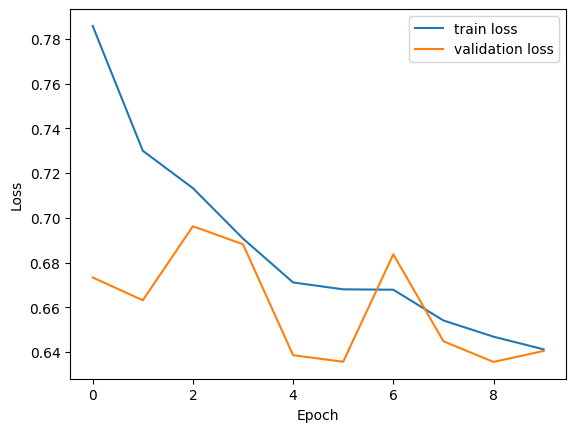

In [91]:
fig, ax = plt.subplots(1,1)

for key in ['train', 'validation']:
    ax.plot(metrics[key]['loss'], label=f'{key} loss')

ax.legend()
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")

#### Visualize

In [21]:
sys.path.append("../..")
from viz_utils.make_video import make_comparison_grid, make_grid_video_with_titles

In [24]:
sample = next(iter(val_dataset))
sample

RuntimeError: Failed to find a valid sample with nonzero modal_mask after 10 tries

In [97]:
scene_rgb = sample['frames']
scene_modal_mask = sample['modal_masks']
gt_amodal_rgb = sample['amodal_content']
gt_amodal_mask = sample['amodal_masks']
pred_amodal_rgb = sample['amodal_content']
pred_amodal_mask = sample['amodal_masks']
n_frames=8 


grid_tensors = make_comparison_grid(scene_rgb=scene_rgb, 
                                    scene_modal_mask=scene_modal_mask,
                                    gt_amodal_rgb=gt_amodal_rgb, 
                                    gt_amodal_mask=gt_amodal_mask,
                                    pred_amodal_rgb=pred_amodal_rgb, 
                                    pred_amodal_mask=pred_amodal_mask,
                                    n_frames=8)

First frame min: 0, max: 255, dtype: uint8


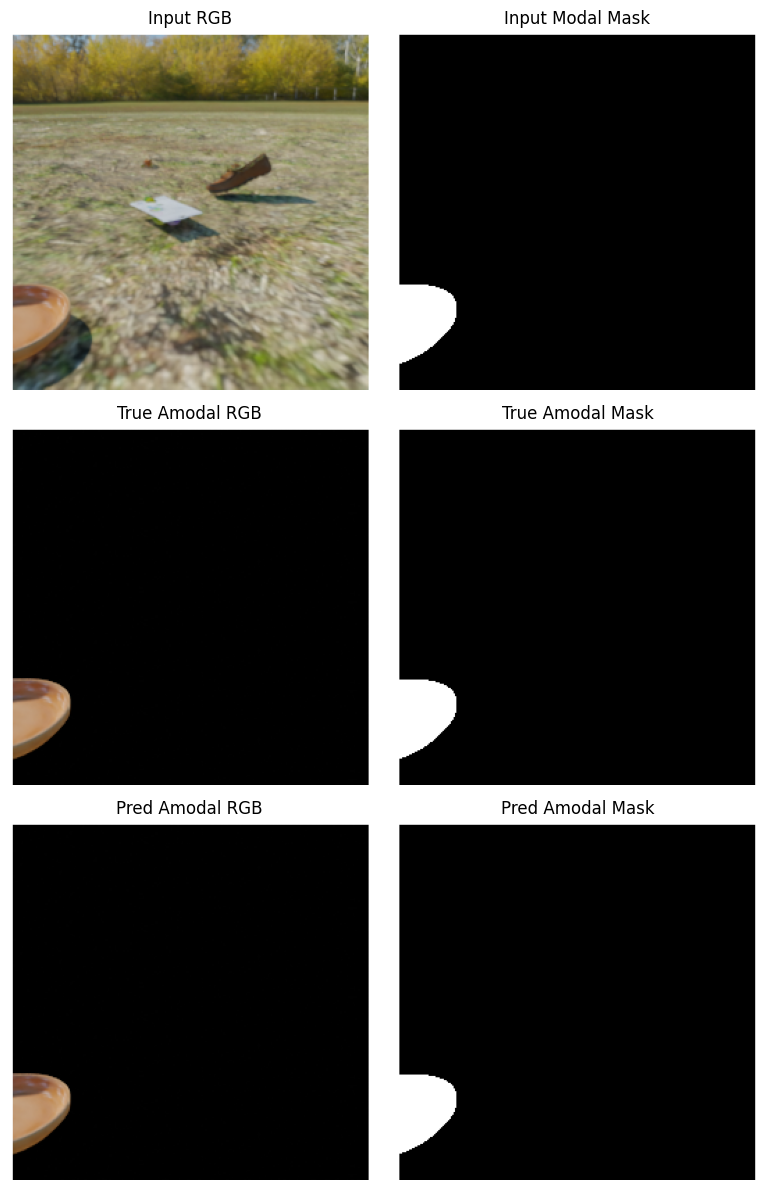

In [98]:
make_grid_video_with_titles(grid_tensors,
                            interval=200, save_path="/p/lustre2/marcou1/dsc2025/test_videos/test_sample_video.gif")

In [39]:
sample.keys()

dict_keys(['frames', 'depths', 'modal_masks', 'amodal_masks', 'amodal_content', 'metadata'])

In [75]:
# Run model forward with one sample
# Fake up a batch with bs =1
# Model forward expects
# frames: (bs, c, n_frames, h, w)
# modal_masks: (bs, 1, n_frames, h, w)
input_batch = {'frames': sample['frames'].unsqueeze(0),
              'modal_masks': sample['modal_masks'].unsqueeze(0),
               'amodal_masks': sample['amodal_masks'].unsqueeze(0), 
               'amodal_content': sample['amodal_content'].unsqueeze(0)}

for key, entry in input_batch.items():
    print(key, entry.shape)

frames torch.Size([1, 3, 8, 256, 256])
modal_masks torch.Size([1, 1, 8, 256, 256])
amodal_masks torch.Size([1, 1, 8, 256, 256])
amodal_content torch.Size([1, 3, 8, 256, 256])


In [53]:
# Run inference
def run_inference_single_sample(model, batch, device):
    """
    Run single sample UnetImage_ConvLSTM inference
    """
    # First things first
    # disable gradient tracking
    with torch.no_grad():
        batch = batch_to_device(batch, device)
        # This takes in a batch - bs =1 for single sample
        # RGB image batch of shape (bs, c, n_frames, h, w)
        # modal_mask (binary, c=1) batch of shape (bs, c, n_frames, h, w)
        # concat rgb and modal masks as input to model

        # frames: (bs, c, n_frames, h, w)
        # modal_masks: (bs, 1, n_frames, h, w)
        frames = batch['frames']         # (bs, c, n_frames, h, w)
        modal_masks = batch['modal_masks']  # (bs, 1, n_frames, h, w)
        frames = modal_masks * frames
        # bs, c, n, h, w = frames.shape


        # # Concatenate along channel dim: (bs, c+1, n_frames, h, w)
        # model_input = torch.cat((frames, modal_masks), dim=1)

        # This time we don't squeeze the time dimension out
        # Prep for loss
        # This is what we use for loss calculations
        # Remember these are bs, c, n, h, w!
        # These both have range 0 to 1 - same to logits
        amodal_mask_labels = batch['amodal_masks'].float()
        amodal_content_labels = batch['amodal_content'].float()

        # Implementation here
        # # Concatenate along channel dim: (bs, c+1, n_frames, h, w)
        # model_input = torch.cat((frames, modal_masks), dim=1)
        x = torch.cat([frames, modal_masks], dim=1)  # (bs, 4, n_frames, h, w)
        bs, c, n_frames, h, w = x.shape
        # Unet_Image encode expects  (bs, 4, n_frames, h, w)
        # Permutation takes (bs, c, n_frames, h, w) --> (bs, n_frames, c, h, w)
        x = x.permute(0, 2, 1, 3, 4)  # (bs, n_frames, c, h, w) --> LSTM expects this

        # Encode frames
        x1_seq, x2_seq, x3_seq, x4_seq = model.encode_frames(x, n_frames)

        # Pass bottleneck (x4_seq) through ConvLSTM
        # Last layer should match dims from encode: torch.Size([6, 256, 1, 16, 16])]
        # ConvLSTM expects B, T, C, H, W
        convlstm_out_list, _ = model.convlstm(x4_seq)  # List of outputs for each layer
        # Returns layer_output_list, last_state_list
        # We only care about the layer output list
        convlstm_out = convlstm_out_list[0]           # (bs, n_frames, channels, h, w)

        # Decoding frames
        # Pass in the sequences of frames and the output of the LSTM
        # Will use the last frame for decoding
        logits_amodal_mask, logits_amodal_content = model.decode_frames(x1_seq, x2_seq, x3_seq, convlstm_out, n_frames)

        # Reshape logits - use permute
        # They come out as bs, n_frames, c, h, w
        # example:
        # torch.Size([8, 8, 3, 256, 256]) torch.Size([8, 8, 1, 256, 256])
        # Batch ground truth is: (bs, c, n_frames, h, w)
        # Example
        # torch.Size([8, 3, 8, 256, 256]) torch.Size([8, 1, 8, 256, 256])
        logits_amodal_mask = logits_amodal_mask.permute(0, 2, 1, 3, 4)
        logits_amodal_content = logits_amodal_content.permute(0, 2, 1, 3, 4)


        # Should we mask the amodal content prediction by the predicted amodal mask?
        if model.mask_content_preds:
            # Element-wise masking by self-predictions:
            logits_amodal_content = logits_amodal_mask.sigmoid().round() * logits_amodal_content

        # print('0000 Verify Shapes 0000')
        # print(logits_amodal_mask.shape)
        # print(logits_amodal_content.shape)
        # print(amodal_mask_labels.shape)
        # print(amodal_content_labels.shape)
        # Loss between predicted amodal masks/content and GT masks/content
        mask_loss, content_loss = model.loss_function(logits_amodal_mask, 
                                                        amodal_mask_labels,
                                                        logits_amodal_content, 
                                                        amodal_content_labels)

        loss = mask_loss + content_loss

        # Compute accuracy
        # If preds are probabilities/logits, binarize them:
        preds_mask = logits_amodal_mask.sigmoid().round() # make binary
        true_mask = amodal_mask_labels.round() # make these binary as well
        # Ensure labels are also float or int for comparison
        # Calculate number of correct pixels
        correct = (preds_mask == true_mask).float().sum()
        # Calculate total number of pixels (numel = number of total elements)
        total = torch.numel(preds_mask)
        # Accuracy
        accuracy = correct / total # this is a number 0 to 1

        # Calculate metrics into a dictionary
        metrics = calculate_metrics(logits_amodal_mask, 
                                    amodal_mask_labels, 
                                    logits_amodal_content,
                                    amodal_content_labels)

        # Report the metrics we calculated in addition to our loss functions
        metrics = {
            'loss': loss.data.item(),
            'mask_loss': mask_loss.data.item(),
            'content_loss': content_loss.data.item(),
            'accuracy': accuracy # add more metrics here - just make sure they are a number
        }
        
    return loss, metrics, logits_amodal_mask, logits_amodal_content

In [76]:
loss, metrics, logits_amodal_mask, logits_amodal_content = run_inference_single_sample(model=model, batch=input_batch, device=device)

In [77]:
print("mask", logits_amodal_mask.min(), logits_amodal_mask.max())
print("content", logits_amodal_content.min(), logits_amodal_content.max())
print(metrics)

mask tensor(-0.4928) tensor(13.3382)
content tensor(-4.5592) tensor(1.8090)
{'loss': 0.6082460284233093, 'mask_loss': 0.5906590819358826, 'content_loss': 0.017586959525942802, 'accuracy': tensor(0.9831)}


In [57]:
logits_amodal_content.shape

torch.Size([1, 3, 8, 256, 256])

In [56]:
print(gt_amodal_rgb.shape, gt_amodal_mask.shape)

torch.Size([3, 8, 256, 256]) torch.Size([1, 8, 256, 256])


In [56]:
def convert_output_to_sample_video_input_format(logits_amodal_content, logits_amodal_mask, true_amodal_content, true_amodal_mask):
    """
    Convert single sample Unet evaluation (logits), to plotting ready numpy arrays
    Unet_Image ground truth: true_amodal_content, true_amodal_mask

    Args:
        logits_amodal_content: torch.tensor, [bs, c, n_frames, h, w]
        logits_amodal_mask: torch.tensor [bs, 1, c, n_frames, h, w]
        true_amodal_content: torch.tensor [c, n_frames, h, w]
        true_amodal_mask: torch.tensor [c, n_frames, h, w]

    Returns:
        preds_amodal_content: torch.tensor [c, n_frames, h, w]
        preds_amodal_mask: torch.tensor [c, n_frames, h, w]
    """
    # 1. RGB Content
    # print("AMODAL RGB CONTENT")
    # print("Logits amodal content, initial (after masking): logits amodal content shape", logits_amodal_content.shape, 
    #     "range", logits_amodal_content.min(), logits_amodal_content.max())

    # These are masked amodal contents for the object
    # Apply sigmoid to logits for amodal content (no rounding!)
    logits_amodal_content = logits_amodal_content.sigmoid()
    # print("Logits amodal content, masked and sigmoid applied: logits amodal content shape", logits_amodal_content.shape, 
    #     "range", logits_amodal_content.min(), logits_amodal_content.max())

    # Squeeze to remove the batch dimensions
    preds_amodal_content = logits_amodal_content.squeeze(0)
    # print("Preds Amodal RGB, after squeeze: preds_amodal_content shape", 
    #     preds_amodal_content.shape, "range", preds_amodal_content.min(), preds_amodal_content.max())


    preds_amodal_content = preds_amodal_content.cpu()

    # Apply clip
    preds_amodal_content = torch.clamp(preds_amodal_content, min=0, max=1)

    # Multiply by 255 to get color range
    preds_amodal_content = (preds_amodal_content * 255).to(torch.uint8)     # [0, 255], uint8
    # print("Preds Amodal RGB, after multiply and int: preds_amodal_content shape", 
    #     preds_amodal_content.shape, "range", preds_amodal_content.min(), preds_amodal_content.max())

    print(f"AMODAL CONTENT: true {true_amodal_content.shape}, pred {preds_amodal_content.shape}")
    print("range comparison\n", 
        f"true {true_amodal_content.min()}, {true_amodal_content.max()}\n",
        f"preds {preds_amodal_content.min()}, {preds_amodal_content.max()}\n")

    # check shape
    assert preds_amodal_content.shape == true_amodal_content.shape


    # 2. Amodal Mask
    # print("AMODAL RGB MASK")

    # print("Logits amodal mask, initial: shape", logits_amodal_mask.shape, 
    #     "range", logits_amodal_mask.min(), logits_amodal_mask.max())

    # Apply rounded sigmoids to get integers, binary
    preds_amodal_mask = logits_amodal_mask.sigmoid().round().to(torch.uint8)
    # This yields bs, c, h, w
    # print("Preds amodal mask, after sigmoid: shape", preds_amodal_mask.shape, 
    #     "range", preds_amodal_mask.min(), preds_amodal_mask.max())

    # Drop ix = 0 (batch dimension)
    preds_amodal_mask = preds_amodal_mask.squeeze(0)            # [1, H, W]
    # print("Preds amodal mask, after dropping bs: shape", preds_amodal_mask.shape, 
    #     "range", preds_amodal_mask.min(), preds_amodal_mask.max())

    preds_amodal_mask = preds_amodal_mask.cpu()    # For probability map (grayscale)


    print(f"AMODAL MASK: true {true_amodal_mask.shape}, pred {preds_amodal_mask.shape}")
    print("range comparison\n", 
        f"true {true_amodal_mask.min()}, {true_amodal_mask.max()}\n",
        f"preds {preds_amodal_mask.min()}, {preds_amodal_mask.max()}\n")

    # check shape
    assert preds_amodal_content.shape == true_amodal_content.shape


    return preds_amodal_content, preds_amodal_mask

In [78]:
preds_amodal_content, preds_amodal_mask = convert_output_to_sample_video_input_format(logits_amodal_content=logits_amodal_content,
                                                                                      logits_amodal_mask=logits_amodal_mask,
                                                                                      true_amodal_content=gt_amodal_rgb,
                                                                                      true_amodal_mask=gt_amodal_mask)


AMODAL CONTENT: true torch.Size([3, 8, 256, 256]), pred torch.Size([3, 8, 256, 256])
range comparison
 true 0.0, 0.7058823704719543
 preds 2, 219

AMODAL MASK: true torch.Size([1, 8, 256, 256]), pred torch.Size([1, 8, 256, 256])
range comparison
 true 0.0, 1.0
 preds 0, 1



In [81]:
scene_rgb = sample['frames']
scene_modal_mask = sample['modal_masks']
scene_rgb = sample['frames'] * scene_modal_mask
gt_amodal_rgb = sample['amodal_content']
gt_amodal_mask = sample['amodal_masks']
pred_amodal_rgb = preds_amodal_content
pred_amodal_mask = preds_amodal_mask
n_frames=8 

grid_tensors = make_comparison_grid(scene_rgb=scene_rgb, 
                                    scene_modal_mask=scene_modal_mask,
                                    gt_amodal_rgb=gt_amodal_rgb,
                                    gt_amodal_mask=gt_amodal_mask,
                                    pred_amodal_rgb=pred_amodal_rgb,
                                    pred_amodal_mask=preds_amodal_mask,
                                    n_frames=8)

In [59]:
sample['metadata']

{'scene': '9702ac6b913341a3a8938aa809e444c3',
 'cam_id': 'camera_0004',
 'obj_id': 'obj_0014',
 'n_tot_objects_in_scene': 14}

First frame min: 0, max: 255, dtype: uint8


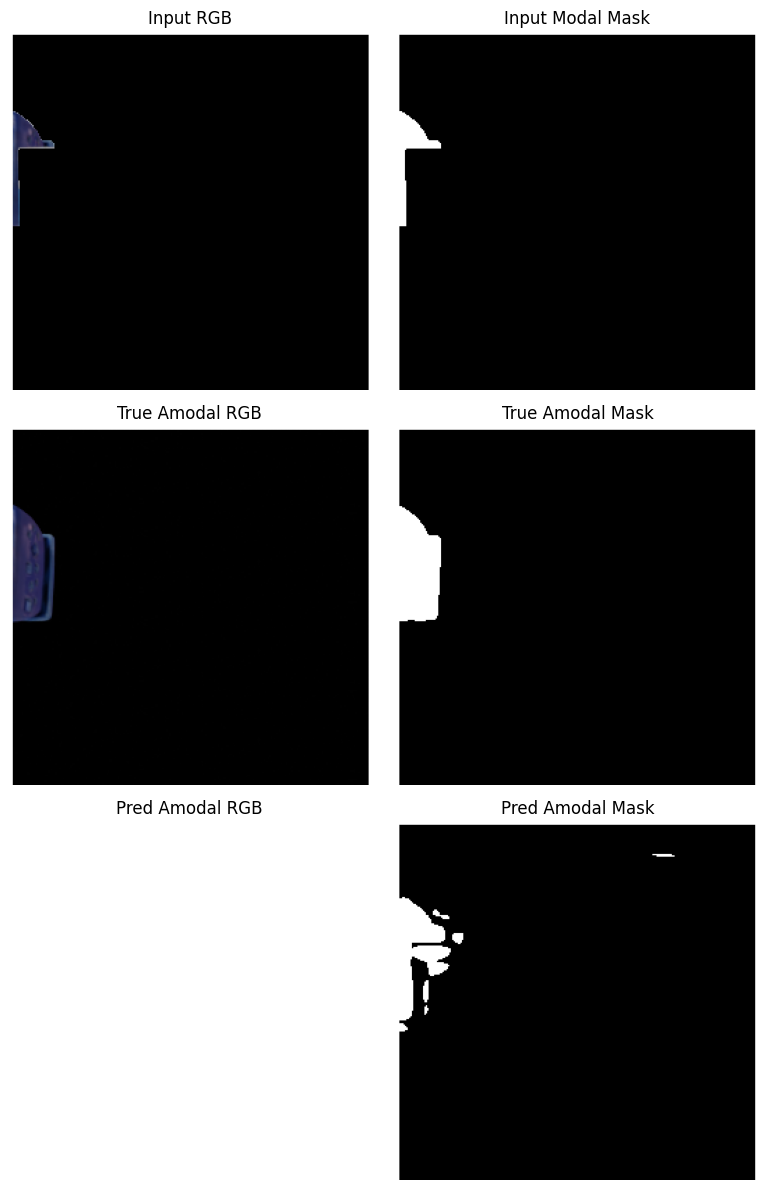

In [82]:
# Make video
make_grid_video_with_titles(grid_tensors,
                            interval=200, 
                            save_path="/p/lustre2/marcou1/dsc2025/test_videos/test_sample_inference_{}_{}_{}.gif".format(sample['metadata']['scene'],
                                                                                                                  sample['metadata']['cam_id'],
                                                                                                                   sample['metadata']['obj_id']))